### Fitting model description
那过程就大概是这样
1. 先用 3 个voigt (elastic + phonons) 1 个 convoluted DHO (CDF) 拟合数据
2. 用拟合结果把 elastic 减掉
3. 用 simulation 把两个phonon减掉
4. 把最后的结果去拟合 CDF 

In [8]:
import sys 
sys.path.append('codes')
from scipy.optimize import curve_fit
import MyFunctions as mf
import matplotlib.pyplot as plt
import rixs_tools as rt
from scipy.signal import convolve
import numpy as np
# from rixs_experiment import RIXS_EXP 
System = rt.create_system()


In [9]:

import numpy as np
from scipy.optimize import curve_fit

class RIXS_EXP():
    def __init__(self):
        self.__name__ = 'rixs_experiment'
        self.__material__ = "LSCO-Eu at p=0.125"
        self.__edge__ = "Oxygen K-edge"
        self.__incident_energy__ = 529
        self._temperature_list_K = [21,62,104,155]
        self._temperature_list_meV = np.array([21,62,104,155])*0.0862  
        self._temperature_list_string = ['T21K','T62K','T104K','T155K']  
        self._q_list = np.array([0.05, 0.1, 0.15, 0.18, 0.2, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.287])
        self._q_size = len(self._q_list)
        self._temperature_size = len(self._temperature_list_K)
        self._resolution = 22.22
        self._fG_preset = 16.875
        self._fL_preset = 9
        self._Raw_data = dict(  T21K = np.genfromtxt(('./simulation_data/'+'21K'+'.csv'), delimiter=','),
                                T62K = np.genfromtxt(('./simulation_data/'+'62K'+'.csv'), delimiter=','),
                                T104K = np.genfromtxt(('./simulation_data/'+'104K'+'.csv'), delimiter=','),
                                T155K = np.genfromtxt(('./simulation_data/'+'155K'+'.csv'), delimiter=','))
        self._Raw_data['T21K'] = self._Raw_data['T21K'][0:1195:,:]
        self._Raw_data['T62K'] = self._Raw_data['T62K'][0:1195:,:]
        self._Raw_data['T104K'] = self._Raw_data['T104K'][0:1195:,:]
        self._Raw_data['T155K'] = self._Raw_data['T155K'][0:1195:,:]
        self._interesting_range_index = [246, 307]
        self._interesting_range = [-80, 150]
        self._Interesting_raw_data = dict(\
            T21K = self._Raw_data['T21K'][self._interesting_range_index[0]:self._interesting_range_index[1],:], 
            T62K = self._Raw_data['T62K'][self._interesting_range_index[0]:self._interesting_range_index[1],:], 
            T104K = self._Raw_data['T104K'][self._interesting_range_index[0]:self._interesting_range_index[1],:], 
            T155K = self._Raw_data['T155K'][self._interesting_range_index[0]:self._interesting_range_index[1],:])
        
        self.Aligned_interesting_data = dict(T21K = np.copy((self._Interesting_raw_data['T21K'])),\
                                                T62K = np.copy((self._Interesting_raw_data['T62K'])),\
                                                T104K = np.copy((self._Interesting_raw_data['T104K'])),\
                                                T155K = np.copy((self._Interesting_raw_data['T155K'])))

                                            
        self.Fit_results = dict(fitting_info=[], T21K = dict(optimized_parameters=[[] for i in range(self._q_size)],errors=[[] for i in range(self._q_size)]),\
                                T62K = dict(optimized_parameters=[[] for i in range(self._q_size)],errors=[[] for i in range(self._q_size)]),\
                                T104K = dict(optimized_parameters=[[] for i in range(self._q_size)],errors=[[] for i in range(self._q_size)]),\
                                T155K = dict(optimized_parameters=[[] for i in range(self._q_size)],errors=[[] for i in range(self._q_size)]))
        self.Subtracted_realigned_interesting_data = dict(T21K = np.zeros(np.shape(self._Interesting_raw_data['T21K'])),\
                                                T62K = np.zeros(np.shape(self._Interesting_raw_data['T62K'])),\
                                                T104K = np.zeros(np.shape(self._Interesting_raw_data['T104K'])),\
                                                T155K = np.zeros(np.shape(self._Interesting_raw_data['T155K'])))
        self.Interpolated_subtracted_realigned_interesting_data = dict(T21K = np.zeros(np.shape(self._Interesting_raw_data['T21K'])),\
                                                T62K = np.zeros(np.shape(self._Interesting_raw_data['T62K'])),\
                                                T104K = np.zeros(np.shape(self._Interesting_raw_data['T104K'])),\
                                                T155K = np.zeros(np.shape(self._Interesting_raw_data['T155K'])))


    @property
    def Raw_data(self):
        return self._Raw_data
    @property
    def q_list(self):
        return self._q_list
    @property
    def temperature_list_K(self):
        return self._temperature_list_K
    @property
    def temperature_list_eV(self):
        return self._temperature_list_eV
    @property
    def temperature_list_string(self):
        return self._temperature_list_string
    @property
    def Interesting_raw_data(self):
        return self._Interesting_raw_data



    def info(self):
        print("\n call `q_list` for the list of q in the experiment \n \
               call `temperature_list_K` for the list of temperature in Kelvin \n \
               call `temperature_list_eV` for the list of temperature in eV \n \
               call `Raw_data` for the raw data of the experiment. \n")
    
    def align_data(self, method = None):
        if method == None:
            T_list_chars = self._temperature_list_string
            for T_char in T_list_chars:
                data_T = self.Interesting_raw_data[T_char]
                for i in range(self._q_size):
                    energy = data_T[:,2*i]
                    intensity = data_T[:,2*i+1]
                    max_energy = energy[np.argmax(intensity)]
                    aligned_energy = energy - max_energy
                    self.Aligned_interesting_data[T_char][:,2*i] = aligned_energy
        elif method == 'gaussian':
            T_list_chars = self._temperature_list_string
            for T_char in T_list_chars:
                data_T = self.Interesting_raw_data[T_char]
                for i in range(self._q_size):
                    energy = data_T[:,2*i]
                    intensity = data_T[:,2*i+1]
                    resolution = self._resolution
                    # fit the data with a gaussian
                    fit_energy = energy[(energy>-resolution/2) & (energy<resolution/2)]
                    fit_intensity = intensity[(energy>-resolution/2) & (energy<resolution/2)]
                    popt,_ = curve_fit(mf.fun_gaussian, fit_energy, fit_intensity, p0=[0, 5, resolution])
                    max_energy = popt[0]
                    aligned_energy = energy - max_energy
                    self.Aligned_interesting_data[T_char][:,2*i] = aligned_energy


    def plot_data(self, T_char, q_index, ax = None):
        """
        Plot the raw data of the experiment
        
        keyword arguments:
        -----------------------------
        - (char) | T_char : 'T21K', 'T62K', 'T104K', 'T155K'
        - (int) | q_index : from 0 to 12
        - (ax) | ax : matplotlib axis to plot the data
        """
        data_T = self.Aligned_interesting_data[T_char]
        energy = data_T[:,2*q_index]
        intensity = data_T[:,2*q_index+1]
        if ax == None:
            plt.plot(energy, intensity, '.', label = T_char+' q='+str(self.q_list[q_index]), markersize = 7)
            ax.legend()
            ax.legend(loc='upper right')
        else:
            ax.plot(energy, intensity, '.', label = T_char+' q='+str(self.q_list[q_index]), markersize = 7)
            ax.legend()
            ax.legend(loc='upper right')
 

    def basic_fit(self, temperature_char, q_index, fun, parameters_guess, parameters_bound, sigma = None):
        """
        Fit the data with a given function
        
        keyword arguments:
        -----------------------------
        - (char) | temperature_char : 'T21K', 'T62K', 'T104K', 'T155K'
        - (int) | q_index : from 0 to 12
        - (function) | fun : function to fit the data
        - (list) | parameters_guess : guess of the parameters of the function
        - (list) | parameters_bound : bounds of the parameters of the function
        """
        data_T = self.Aligned_interesting_data[temperature_char]
        energy = data_T[:,2*q_index]
        intensity = data_T[:,2*q_index+1]
        popt, pcov = curve_fit(fun, energy, intensity, p0=parameters_guess, bounds=parameters_bound, sigma=sigma)
        return popt, np.sqrt(np.diag(pcov))
    
    def plot_fit_conponent(self, fun_conponent, parameters, fill = False, ax = None, label = None, color = 'lightgrey'):
        """
        Plot the fit of the data with a given function
        
        keyword arguments:
        -----------------------------
        - (function) | fun_conponent : function to fit the data
        - (array) | parameters : parameters of the function
        """
        energy = np.linspace(self._interesting_range[0], self._interesting_range[1], 300)
        intensity = fun_conponent(energy, *parameters)
        if ax == None:
            if not fill:
                plt.plot(energy, intensity, label = label, color = color)
            else:
                plt.fill_between(energy, intensity, alpha=0.8, label = label, color = color, edgecolor = 'none')
        else:
            if not fill:
                ax.plot(energy, intensity, label = label, color = color)
            else:
                ax.fill_between(energy, intensity, alpha=0.8, label = label, color = color, edgecolor = 'none')


exp = RIXS_EXP()

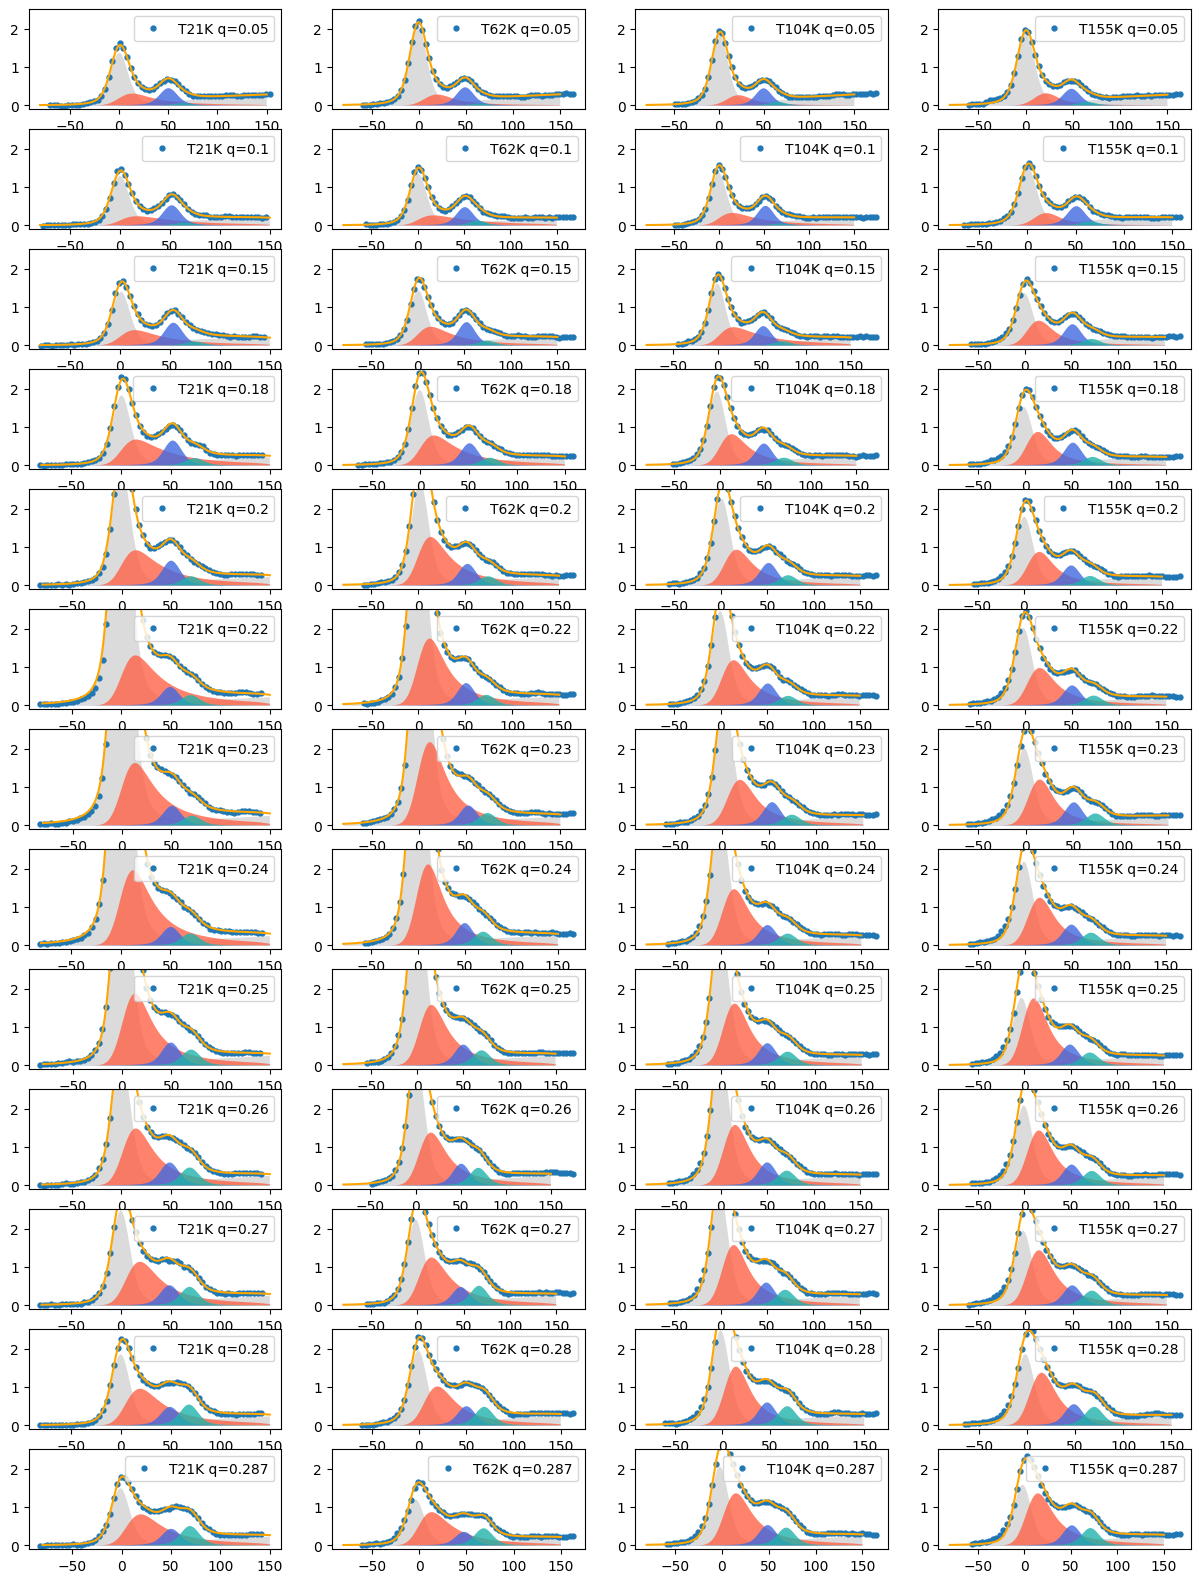

In [73]:
# basic fitting
fL = exp._fL_preset
fG = exp._fG_preset
global T

def fun_DHO_bose(x,x0,A,res):
    return mf.fun_DHO_original(x,x0,A,res) * 1/(1+np.exp(-x/T))

def function_to_fit(x, *parameters):
    res = exp._resolution
    global T
    y1 = mf.fun_voigt(x, *parameters[0:4])  # elastic
    # y2 = fun_DHO_bose(x,*parameters[4:7]) # CDF
    # y2 = mf.fun_DHO(x,*parameters[4:7]) # CDF
    y2 = mf.convoluted_fun(x, res, mf.fun_DHO, *parameters[4:7]) # CDF
    # y2 = mf.fun_lorentzian(x, *parameters[4:7]) # CDF
    # y2 = mf.fun_gaussian(x, *parameters[4:7]) # CDF
    y3 = mf.fun_voigt(x, *parameters[7:9], *parameters[2:4]) # 1st phonon 
    y4 = mf.fun_voigt(x, *parameters[9:11], *parameters[2:4]) # 2nd phonon
    y5 = mf.fun_voigt(x, *parameters[11:13], *parameters[2:4]) # 3rd phonon
    y6 = mf.fun_quadratic(x, *parameters[13:15])# background
    return y1+y2+y3+y4+y5+y6 

temperature_chars = exp._temperature_list_string
res = exp._resolution
fig, axs = plt.subplots(13,4,figsize=(15,20))
for i,temperature_char in enumerate(temperature_chars):
    T = exp._temperature_list_meV[i]
    p0 =        [0, 5, fG, fL,\
                20, 1, 20,\
                40, 0.5,\
                52, 0,\
                75, 0.1,\
                160, 0.2]
    popt =      [0, 5, fG, fL,\
                20, 1, 20,\
                40, 0.5,\
                52, 0,\
                75, 0.1,\
                160, 0.2]
    for j,q_index in enumerate(range(exp._q_size)):
        ax = axs[j,i]

        # test the function
        x = np.linspace(-80,150,1000)

        f_epsilon = 0.2
        epsilon = 0.001
        parameters_guess = popt


        parameters_lower = [-10, 0, fG-f_epsilon, fL-f_epsilon,\
                            0, 0, 0, \
                            20, 0,\
                            40, 0,\
                            65, 0,\
                            100, 0]
        parameters_upper = [10, 10, fG+f_epsilon, fL+f_epsilon,\
                            40, 10, 100,\
                            70, 10,\
                            70, 0+epsilon,\
                            105, 10,\
                            500, 10]
        data_T = exp.Aligned_interesting_data[temperature_char]
        energy = data_T[:,2*q_index]
        intensity = data_T[:,2*q_index+1]
        sigma = np.ones(len(energy))
        #sigma[(energy>-16)&(energy<30)] = 0.7
        popt, perr = exp.basic_fit(temperature_char, q_index, function_to_fit, parameters_guess, parameters_bound=(parameters_lower, parameters_upper),sigma = sigma)        
        exp.Fit_results[temperature_char]['optimized_parameters'][q_index] = popt
        exp.Fit_results[temperature_char]['errors'][q_index] = perr
        exp.Fit_results[temperature_char]['fitting_info'] = "voigt for background, lorentzian for CDF, voigt for 3 phonons, quadratic for background"
        exp.plot_data(temperature_char, q_index, ax = ax)
        exp.plot_fit_conponent(function_to_fit, popt, ax = ax, fill = False, label = 'fit', color = 'orange') # total fit
        exp.plot_fit_conponent(mf.fun_voigt, popt[0:4], ax = ax, fill = True, label = 'elastic', color = 'lightgrey') # elastic
        exp.plot_fit_conponent(mf.fun_quadratic, popt[13:15], ax = ax, fill = True, label = 'background', color = 'lightgrey') # background
        # exp.plot_fit_conponent(mf.fun_DHO, popt[4:7], ax = ax, fill = True, label = 'CDF', color = 'tomato') # CDF
        exp.plot_fit_conponent(mf.convoluted_fun, [res,mf.fun_DHO, *popt[4:7]], ax = ax, fill = True, label = 'CDF', color = 'tomato') # CDF
        # exp.plot_fit_conponent(mf.fun_lorentzian, popt[4:7], ax = ax, fill = True, label = 'CDF', color = 'tomato')
        #exp.plot_fit_conponent(mf.fun_gaussian, popt[4:7], ax = ax, fill = True, label = 'CDF', color = 'tomato')
        exp.plot_fit_conponent(mf.fun_voigt, [*popt[7:9],*popt[2:4]], ax = ax, fill = True, label = '1st phonon', color = 'royalblue') # 1st phonon
        exp.plot_fit_conponent(mf.fun_voigt, [*popt[9:11],*popt[2:4]], ax = ax, fill = True, label = '2nd phonon', color = 'lightgreen') # 2nd phonon
        exp.plot_fit_conponent(mf.fun_voigt, [*popt[11:13],*popt[2:4]], ax = ax, fill = True, label = '3rd phonon', color = 'lightseagreen') # 3rd phonon
        ax.set_ylim(-0.1,2.5)
        # set legend to northeast

        # fill the sutracted_realigned_data in exp object by subtracting the elastic and the background
        exp.Subtracted_realigned_interesting_data[temperature_char][:,2*q_index+1] = intensity - mf.fun_voigt(energy, *popt[0:4]) - mf.fun_quadratic(energy, *popt[13:15])
        exp.Subtracted_realigned_interesting_data[temperature_char][:,2*q_index] = energy - popt[0]

        
# save figure
#fig.tight_layout()
#fig.savefig('dho_fitting_results.jpg',dpi=100)




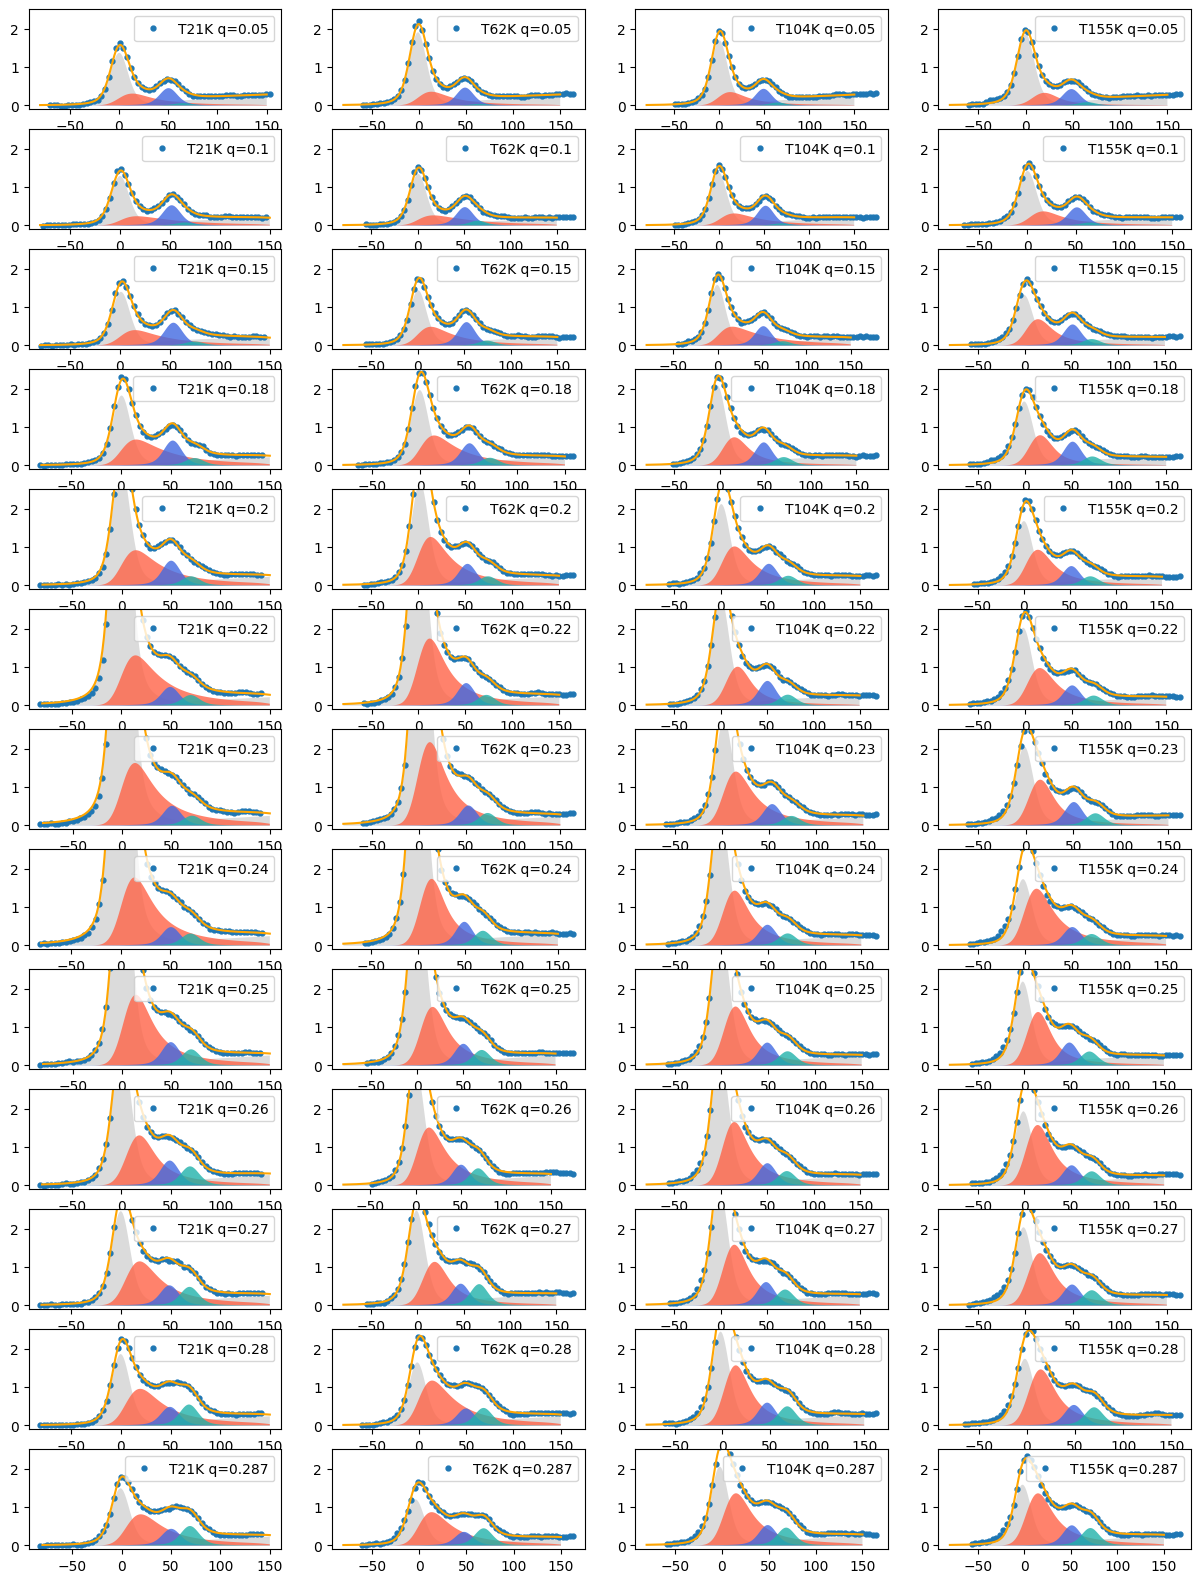

In [77]:

fig, axs = plt.subplots(13,4,figsize=(15,20))
for i,temperature_char in enumerate(temperature_chars):
    T = exp._temperature_list_meV[i]
    CDF_position = exp.Fit_results[temperature_char]['optimized_parameters'][0][4]
    popt =      [0, 5, fG, fL,\
                CDF_position, 1, 20,\
                40, 0.5,\
                52, 0,\
                75, 0.1,\
                160, 0.2]
    for j,q_index in enumerate(range(exp._q_size)):
        ax = axs[j,i]
        CDF_position = exp.Fit_results[temperature_char]['optimized_parameters'][q_index][4]
        # test the function
        x = np.linspace(-80,150,1000)

        f_epsilon = 0.2
        epsilon = 0.001
        parameters_guess = popt
        popt[4] = CDF_position


        parameters_lower = [-10, 0, fG-f_epsilon, fL-f_epsilon,\
                            CDF_position, 0, 0, \
                            20, 0,\
                            40, 0,\
                            65, 0,\
                            100, 0]
        parameters_upper = [10, 10, fG+f_epsilon, fL+f_epsilon,\
                            CDF_position+epsilon, 10, 100,\
                            70, 10,\
                            70, 0+epsilon,\
                            105, 10,\
                            500, 10]
        data_T = exp.Aligned_interesting_data[temperature_char]
        energy = data_T[:,2*q_index]
        intensity = data_T[:,2*q_index+1]
        sigma = np.ones(len(energy))
        #sigma[(energy>-16)&(energy<30)] = 0.7
        popt, perr = exp.basic_fit(temperature_char, q_index, function_to_fit, parameters_guess, parameters_bound=(parameters_lower, parameters_upper),sigma = sigma)        
        exp.Fit_results[temperature_char]['optimized_parameters'][q_index] = popt
        exp.Fit_results[temperature_char]['errors'][q_index] = perr
        exp.Fit_results[temperature_char]['fitting_info'] = "voigt for background, lorentzian for CDF, voigt for 3 phonons, quadratic for background"
        exp.plot_data(temperature_char, q_index, ax = ax)
        exp.plot_fit_conponent(function_to_fit, popt, ax = ax, fill = False, label = 'fit', color = 'orange') # total fit
        exp.plot_fit_conponent(mf.fun_voigt, popt[0:4], ax = ax, fill = True, label = 'elastic', color = 'lightgrey') # elastic
        exp.plot_fit_conponent(mf.fun_quadratic, popt[13:15], ax = ax, fill = True, label = 'background', color = 'lightgrey') # background
        # exp.plot_fit_conponent(mf.fun_DHO, popt[4:7], ax = ax, fill = True, label = 'CDF', color = 'tomato') # CDF
        exp.plot_fit_conponent(mf.convoluted_fun, [res,mf.fun_DHO, *popt[4:7]], ax = ax, fill = True, label = 'CDF', color = 'tomato') # CDF
        # exp.plot_fit_conponent(mf.fun_lorentzian, popt[4:7], ax = ax, fill = True, label = 'CDF', color = 'tomato')
        #exp.plot_fit_conponent(mf.fun_gaussian, popt[4:7], ax = ax, fill = True, label = 'CDF', color = 'tomato')
        exp.plot_fit_conponent(mf.fun_voigt, [*popt[7:9],*popt[2:4]], ax = ax, fill = True, label = '1st phonon', color = 'royalblue') # 1st phonon
        exp.plot_fit_conponent(mf.fun_voigt, [*popt[9:11],*popt[2:4]], ax = ax, fill = True, label = '2nd phonon', color = 'lightgreen') # 2nd phonon
        exp.plot_fit_conponent(mf.fun_voigt, [*popt[11:13],*popt[2:4]], ax = ax, fill = True, label = '3rd phonon', color = 'lightseagreen') # 3rd phonon
        ax.set_ylim(-0.1,2.5)
        # set legend to northeast

        # fill the sutracted_realigned_data in exp object by subtracting the elastic and the background
        exp.Subtracted_realigned_interesting_data[temperature_char][:,2*q_index+1] = intensity - mf.fun_voigt(energy, *popt[0:4]) - mf.fun_quadratic(energy, *popt[13:15])
        exp.Subtracted_realigned_interesting_data[temperature_char][:,2*q_index] = energy - popt[0]

        
# save figure
#fig.tight_layout()
#fig.savefig('dho_fitting_results.jpg',dpi=100)




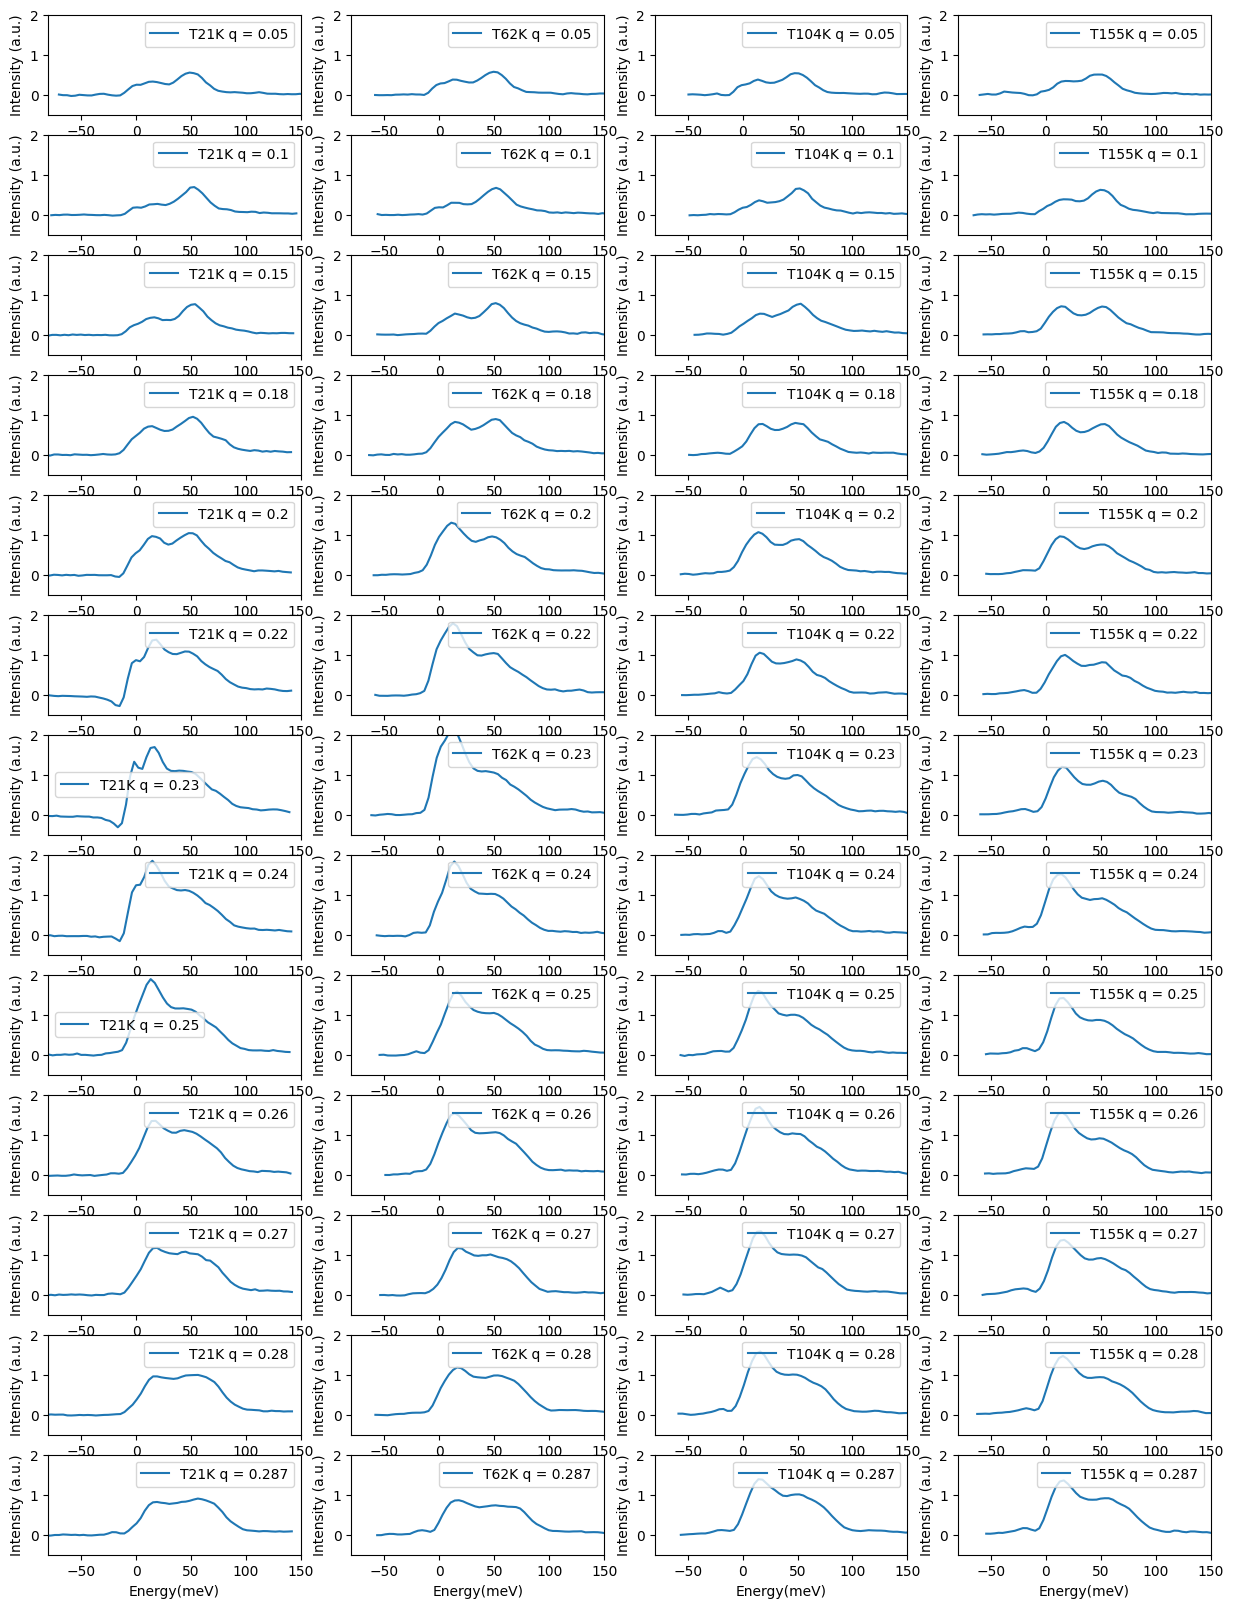

In [78]:
# plot subtracted realigned data
fig, axs = plt.subplots(13,4,figsize=(15,20))
for i,temperature_char in enumerate(temperature_chars):
    T = exp._temperature_list_meV[i]
    for q_index in range(exp._q_size):
        ax = axs[q_index,i]
        ax.plot(exp.Subtracted_realigned_interesting_data[temperature_char][:,2*q_index],exp.Subtracted_realigned_interesting_data[temperature_char][:,2*q_index+1], label = temperature_char + ' q = ' + str(exp.q_list[q_index]))
        ax.set_ylim(-0.5,2)
        ax.set_xlim(-80,150)
        # ax.set_title(temperature_char)
        ax.set_xlabel('Energy(meV)')
        ax.set_ylabel('Intensity (a.u.)')
        ax.legend()

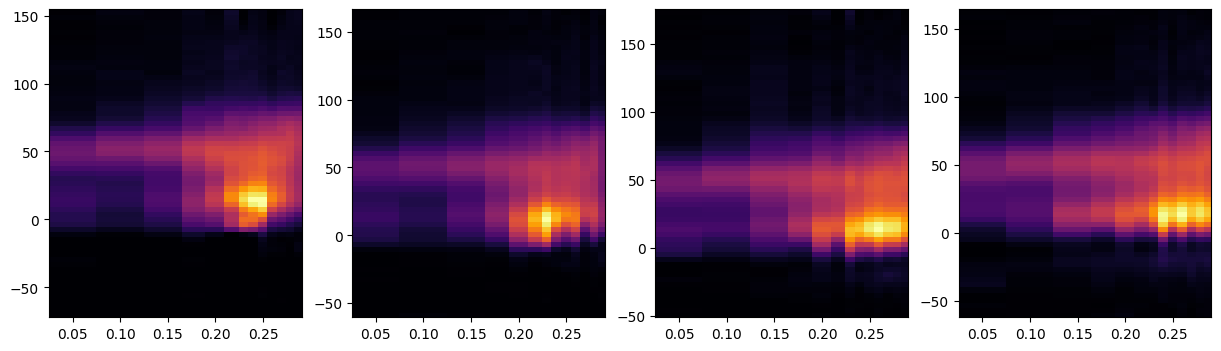

In [79]:
from scipy.interpolate import interp1d

fig,axes = plt.subplots(1,4,figsize=(15,4))


for j,temperature_char in enumerate(exp.temperature_list_string):
    energies = exp.Subtracted_realigned_interesting_data[temperature_char][:,0::2]
    intensities = exp.Subtracted_realigned_interesting_data[temperature_char][:,1::2]
    y_interpolate = exp.Subtracted_realigned_interesting_data[temperature_char][:,0]
    z_interpolate = np.zeros((len(y_interpolate),exp._q_size))
    for i in range(exp._q_size):
        f = interp1d(energies[:,i], intensities[:,i], kind='linear', fill_value='extrapolate')
        z_interpolate[:,i] = f(y_interpolate)
        exp.Interpolated_subtracted_realigned_interesting_data[temperature_char][:,2*i] = y_interpolate
        exp.Interpolated_subtracted_realigned_interesting_data[temperature_char][:,2*i+1] = z_interpolate[:,i]
    X,Y = np.meshgrid(exp.q_list,y_interpolate)
    z_interpolate[z_interpolate<0] = 0
    axes[j].pcolor(X,Y,z_interpolate,cmap='inferno')


In [80]:
from scipy.signal import convolve
def convolve_simulation(x,y,res):
    x_left = min(x)
    x_right = max(x)
    x_left_shifted = x_left - (x_right + x_left)/2
    x_right_shifted = x_right - (x_right + x_left)/2
    x_gaussian = np.linspace(x_left_shifted, x_right_shifted, len(x))
    gaussian_curve = mf.fun_gaussian(x_gaussian, 0, 1, res)
    
    # Calculate fun_s for a range of x values
    max_value = max(y)
    # Convolute fun_s with the Gaussian
    # Assume x is a numpy array for simplicity; adjust as necessary for your case
    convoluted_values = convolve(y, gaussian_curve, mode='same')
    max_convoluted_value = max(convoluted_values)
    return convoluted_values/max_convoluted_value*max_value


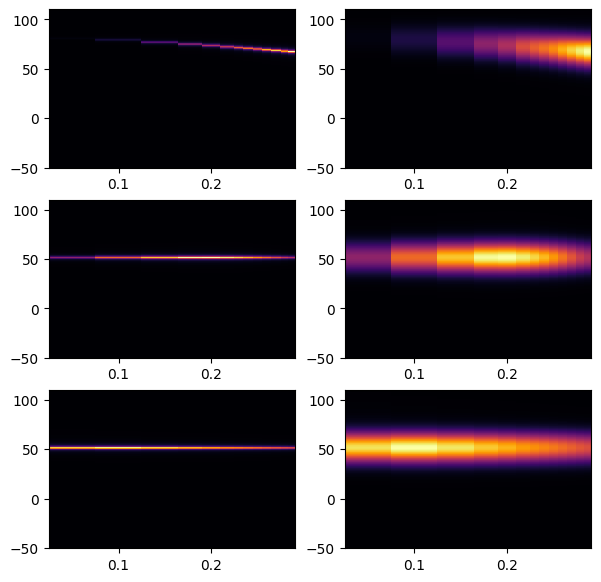

In [81]:
# test
resolution = 23
X_simulation = np.loadtxt('./simulation_data/X.txt')/System.paras.knorm
Y_simulation = np.loadtxt('./simulation_data/Y.txt')
Z_simulation_apical = np.loadtxt('./simulation_data/Z_ap.txt')
Z_simulation_breathing = np.loadtxt('./simulation_data/Z_br.txt')
Z_simulation_a1g = np.loadtxt('./simulation_data/Z_a1g.txt')
Z_simulation_apical[Z_simulation_apical<0] = 0
Z_simulation_breathing[Z_simulation_breathing<0] = 0
Z_simulation_a1g[Z_simulation_a1g<0] = 0
fig,ax = plt.subplots(3,2,figsize=(7,7))


ax[0,0].pcolor(X_simulation,Y_simulation,Z_simulation_breathing,cmap='inferno')
Z_simulation_breathing_conv = np.zeros(np.shape(Z_simulation_breathing))
for q_index,q in enumerate(exp.q_list):
    y = Y_simulation[:,q_index]
    z = Z_simulation_breathing[:,q_index]
    z_conv = convolve_simulation(y,z,resolution)
    Z_simulation_breathing_conv[:,q_index] = z_conv/20
ax[0,1].pcolor(X_simulation,Y_simulation,Z_simulation_breathing_conv,cmap='inferno')


ax[1,0].pcolor(X_simulation,Y_simulation,Z_simulation_apical,cmap='inferno')
Z_simulation_apical_conv = np.zeros(np.shape(Z_simulation_apical))
for q_index,q in enumerate(exp.q_list):
    y = Y_simulation[:,q_index]
    z = Z_simulation_apical[:,q_index]
    z_conv = convolve_simulation(y,z,resolution)
    Z_simulation_apical_conv[:,q_index] = z_conv/20
ax[1,1].pcolor(X_simulation,Y_simulation,Z_simulation_apical_conv,cmap='inferno')

ax[2,0].pcolor(X_simulation,Y_simulation,Z_simulation_a1g,cmap='inferno')
Z_simulation_a1g_conv = np.zeros(np.shape(Z_simulation_a1g))
for q_index,q in enumerate(exp.q_list):
    y = Y_simulation[:,q_index]
    z = Z_simulation_a1g[:,q_index]
    z_conv = convolve_simulation(y,z,resolution)
    Z_simulation_a1g_conv[:,q_index] = z_conv/20
ax[2,1].pcolor(X_simulation,Y_simulation,Z_simulation_a1g_conv,cmap='inferno')


Text(0.5, 1.0, 'a1g')

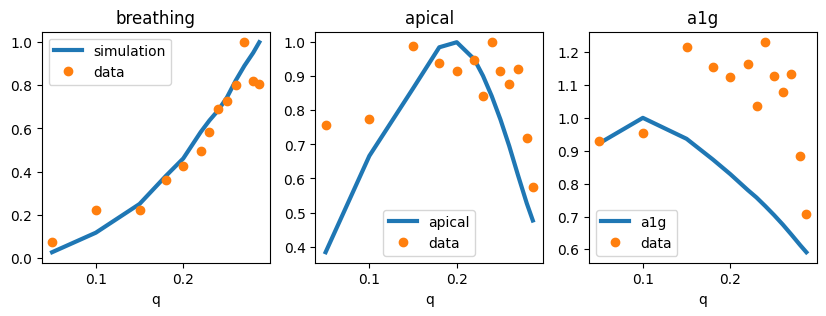

In [82]:
# extract intensity vs q by picking the maximum intensity at each q
fig,ax = plt.subplots(1,3,figsize=(10,3))
I_br = np.zeros(exp._q_size)
I_ap = np.zeros(exp._q_size)
I_a1g = np.zeros(exp._q_size)
I_br_fitting = np.zeros(exp._q_size)
I_ap_fitting = np.zeros(exp._q_size)
I_a1g_fitting = np.zeros(exp._q_size)
Fitting_result = exp.Fit_results['T62K']['optimized_parameters']


for q_index,q in enumerate(exp.q_list):
    I_br[q_index] = max(Z_simulation_breathing_conv[:,q_index])
    I_ap[q_index] = max(Z_simulation_apical_conv[:,q_index])
    I_a1g[q_index] = max(Z_simulation_a1g_conv[:,q_index])
    I_br_fitting[q_index] = Fitting_result[q_index][12]
    I_ap_fitting[q_index] = Fitting_result[q_index][8]
    I_a1g_fitting[q_index] = Fitting_result[q_index][8]


a1g_factor = 1.23

ax[0].plot(exp.q_list,I_br/max(I_br), label = 'simulation',linewidth=3)
ax[0].plot(exp.q_list,I_br_fitting/max(I_br_fitting),'o', label = 'data')
ax[0].set_xlabel('q'); ax[0].legend(); ax[0].set_title("breathing")
ax[1].plot(exp.q_list,I_ap/max(I_ap), label = 'apical',linewidth=3)
ax[1].plot(exp.q_list,I_ap_fitting/max(I_ap_fitting), 'o',label = 'data')
ax[1].set_xlabel('q'); ax[1].legend(); ax[1].set_title("apical")
ax[2].plot(exp.q_list,I_a1g/max(I_a1g), label = 'a1g',linewidth=3)
ax[2].plot(exp.q_list,I_a1g_fitting/max(I_a1g_fitting)*a1g_factor, 'o', label = 'data')
ax[2].set_xlabel('q'); ax[2].legend(); ax[2].set_title("a1g")

Text(0.5, 1.0, 'Subtracted data')

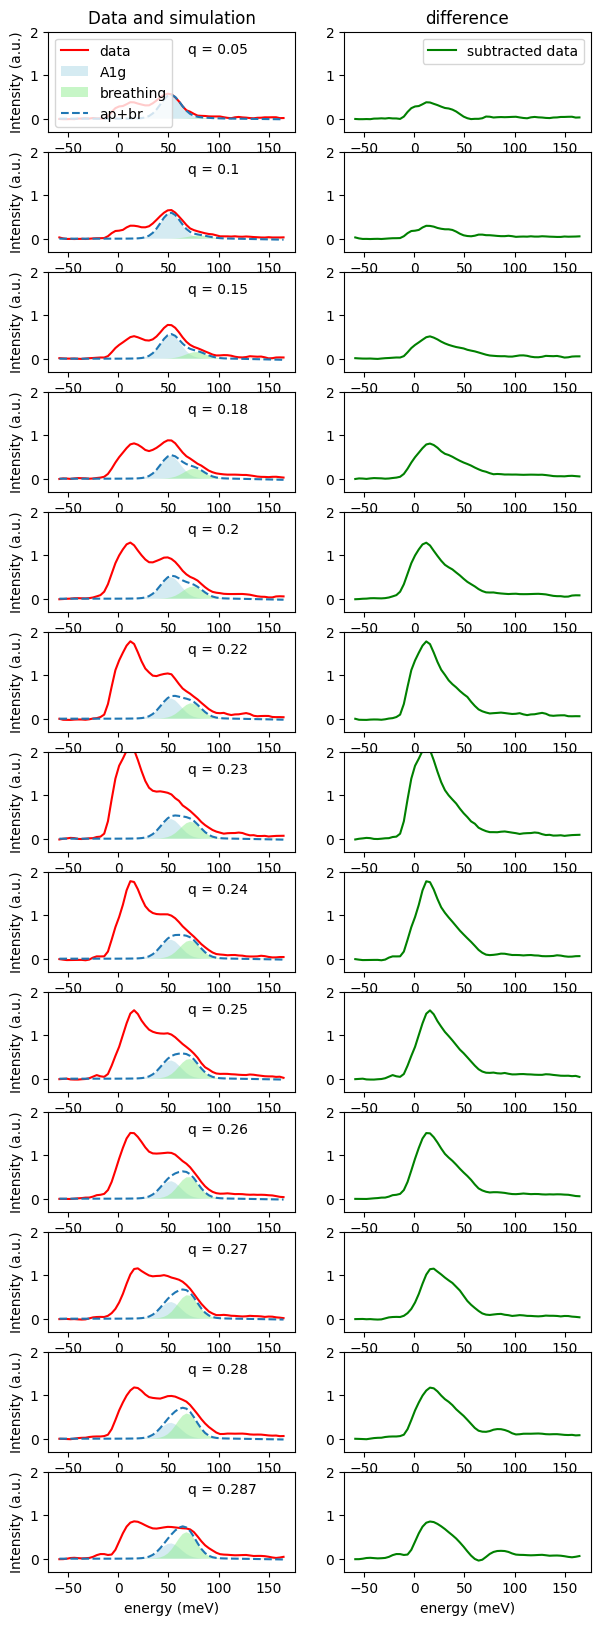

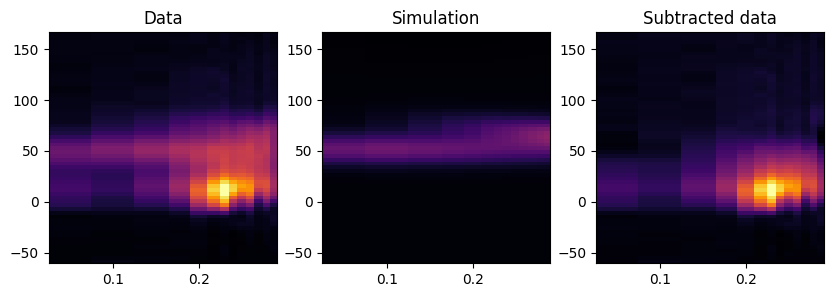

In [83]:
# load T21.cvs # import data
from scipy.interpolate import interp1d
data =exp.Interpolated_subtracted_realigned_interesting_data['T62K']
data_shape = np.shape(data)
num_rows_data = data_shape[0]
num_cols_data = int(data_shape[1]/2)
x_data = np.array([0.05, 0.1, 0.15, 0.18, 0.2, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.287])
i =  5
y_data = data[:, 2*i]
z_data = data[:, 2*i+1]
y_standard = y_data

simulation_shape = np.shape(Z_simulation_apical)
num_rows_simulation = simulation_shape[0]
num_cols_simulation = int(simulation_shape[1])

# create standard-sized arrays
Z_data_standard = np.zeros([len(y_standard), num_cols_data])
Z_simulation_apical_standard = np.zeros([len(y_standard), num_cols_data])
Z_simulation_breathing_standard = np.zeros([len(y_standard), num_cols_data])
Z_simulation_a1g_standard = np.zeros([len(y_standard), num_cols_data])

multiplication_factor_apical = 0.75
multiplication_factor_breathing = 1.4
multiplication_factor_a1g = 1.8
ap = Z_simulation_apical_conv*multiplication_factor_apical
br = Z_simulation_breathing_conv*multiplication_factor_breathing
a1g = Z_simulation_a1g_conv*multiplication_factor_a1g

Z_subtracted = np.zeros([len(y_standard), num_cols_data])

fig, axes = plt.subplots(13,2,figsize=(7,20))
for i in range(num_cols_data):
    y = data[:, 2*i]
    z = data[:, 2*i+1]
    # interpolate Z_simulation with interp1d     
    f_a1g = interp1d(Y_simulation[:,i], a1g[:,i], kind='linear', fill_value='extrapolate')
    f_br = interp1d(Y_simulation[:,i], br[:,i], kind='linear', fill_value='extrapolate')
    
    a1g_interp = f_a1g(y_standard)
    br_interp = f_br(y_standard)
    axes[i][0].plot(y_standard, z, 'r', label='data')
    # plot interpolated simulation will transparent filled curve
    axes[i][0].fill_between(y_standard, a1g_interp, 0, color='lightblue', alpha=0.5, edgecolor='none', label='A1g')
    axes[i][0].fill_between(y_standard, br_interp, 0, color='lightgreen', alpha=0.5, edgecolor='none', label='breathing')
    axes[i][0].plot(y_standard, br_interp+a1g_interp, '--', label='ap+br')
    # legend
    axes[i][1].plot(y_standard,z-a1g_interp-br_interp, 'g', label='subtracted data')
    Z_data_standard[:, i] = z
    Z_simulation_a1g_standard[:, i] = a1g_interp
    Z_simulation_breathing_standard[:, i] = br_interp
    Z_subtracted[:, i] = z-a1g_interp-br_interp
    # y range from -0.1 to 1.5
    axes[i][0].set_ylim([-0.3, 2])
    axes[i][1].set_ylim([-0.3, 2])
    # add corresonding x_data to the top right corner
    axes[i][0].text(70, 1.5, 'q = '+str(x_data[i]), fontsize=10)

    # titles and y labels
    if i == 0:
        axes[i][0].set_title('Data and simulation')
        axes[i][1].set_title('difference')
        # legend
        axes[i][0].legend(loc='upper left')
        axes[i][1].legend(loc='upper right')
    axes[i][0].set_ylabel('Intensity (a.u.)')
    if i == num_cols_data-1:
        axes[i][0].set_xlabel('energy (meV)')
        axes[i][1].set_xlabel('energy (meV)')

fig, ax = plt.subplots(1,3,figsize=(10,3))
ax[0].pcolor(x_data,y_standard,Z_data_standard,cmap='inferno',vmax = 2)
ax[0].set_title('Data')
ax[1].pcolor(x_data,y_data, Z_simulation_a1g_standard+Z_simulation_breathing_standard, cmap='inferno',vmax = 2)
ax[1].set_title('Simulation')
ax[2].pcolor(x_data,y_standard,Z_subtracted,cmap='inferno',vmax = 2)
ax[2].set_title('Subtracted data')

# save figure
# plt.savefig('lesco_method4_data_subracted_by_simulation.jpg', dpi=100, bbox_inches='tight')






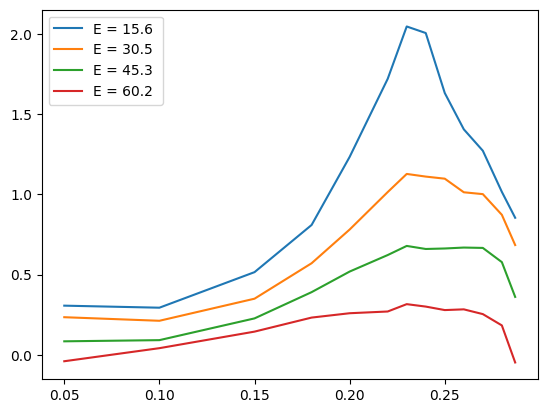

In [60]:
# legend keep 1 digit
plt.plot(x_data,Z_subtracted[20,:], label = f"E = {y_data[20]:.1f} ")

plt.plot(x_data,Z_subtracted[24,:], label = f"E = {y_data[24]:.1f} ")

plt.plot(x_data,Z_subtracted[28,:], label = f"E = {y_data[28]:.1f} ")

plt.plot(x_data,Z_subtracted[32,:], label = f"E = {y_data[32]:.1f} ")

plt.legend()

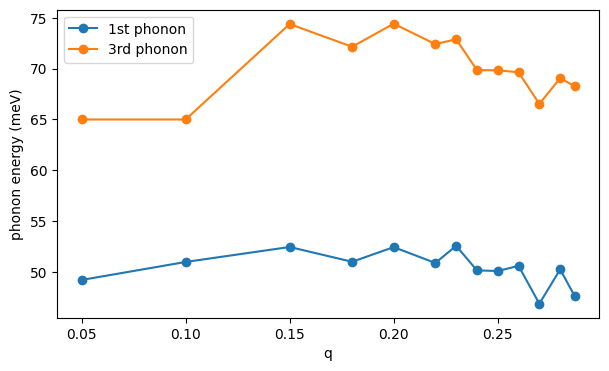

In [27]:
# plotting the first fitting parameter for each phonons as a function of q at 21K
fig, ax = plt.subplots(1,1,figsize=(7,4))
temperature_char = 'T62K'
phonon1_energy = np.zeros(exp._q_size)
phonon2_energy = np.zeros(exp._q_size)
phonon3_energy = np.zeros(exp._q_size)
for q_index in range(exp._q_size):
    phonon1_energy[q_index] = exp.Fit_results[temperature_char]['optimized_parameters'][q_index][7]
    phonon2_energy[q_index] = exp.Fit_results[temperature_char]['optimized_parameters'][q_index][9]
    phonon3_energy[q_index] = exp.Fit_results[temperature_char]['optimized_parameters'][q_index][11]

ax.plot(exp._q_list, phonon1_energy, '-o', label = '1st phonon')
#ax.plot(exp._q_list, phonon2_energy, '-o', label = '2nd phonon')
ax.plot(exp._q_list, phonon3_energy, '-o', label = '3rd phonon')
ax.set_xlabel('q')
ax.set_ylabel('phonon energy (meV)')
ax.legend()


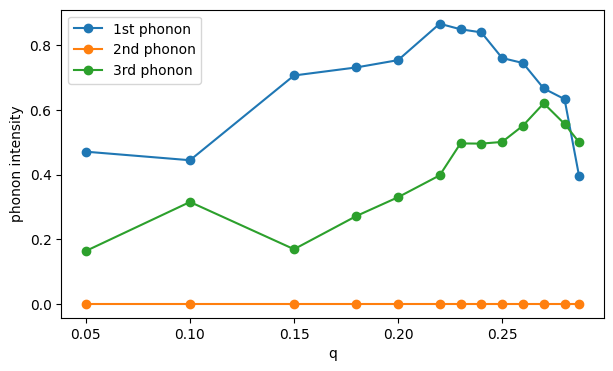

In [8]:
# plotting the second fitting parameter for each phonons as a function of q at 21K
fig, ax = plt.subplots(1,1,figsize=(7,4))
phonon1_intensity = np.zeros(exp._q_size)
phonon2_intensity = np.zeros(exp._q_size)
phonon3_intensity = np.zeros(exp._q_size)
for q_index in range(exp._q_size):
    phonon1_intensity[q_index] = exp.Fit_results[temperature_char]['optimized_parameters'][q_index][8]
    phonon2_intensity[q_index] = exp.Fit_results[temperature_char]['optimized_parameters'][q_index][10]
    phonon3_intensity[q_index] = exp.Fit_results[temperature_char]['optimized_parameters'][q_index][12]

ax.plot(exp._q_list, phonon1_intensity, '-o', label = '1st phonon')
ax.plot(exp._q_list, phonon2_intensity, '-o', label = '2nd phonon')
ax.plot(exp._q_list, phonon3_intensity, '-o', label = '3rd phonon')
ax.set_xlabel('q')
ax.set_ylabel('phonon intensity')
ax.legend()


In [7]:
print(f" FWHM at 155K is {exp.Fit_results['T155K']['optimized_parameters'][8][6]}")
print(f" FWHM at 104K is {exp.Fit_results['T104K']['optimized_parameters'][8][6]}")
print(f" FWHM at 62K is {exp.Fit_results['T62K']['optimized_parameters'][8][6]}")
print(f" FWHM at 21K is {exp.Fit_results['T21K']['optimized_parameters'][8][6]}")

 FWHM at 155K is 28.347285275512377
 FWHM at 104K is 22.220000000000002
 FWHM at 62K is 22.220000000000002
 FWHM at 21K is 22.220000000000002


### remarks
1. from 21K - 104K the FWHM of Lorentzian is the resolution.
2. This means that we can't get the "*original*" FWHM by deconvoluting it with a Gaussian
3. 3-phonon fitting might not work here if we want to extract the $\Delta$ and $\Gamma$ information of the CDF


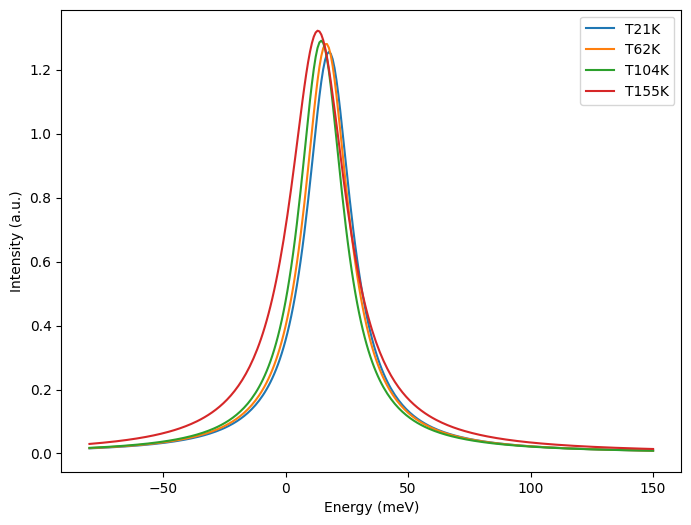

In [8]:
cdf_index = 8
# plot the CDF ay different temperatures
fig, ax = plt.subplots(1,1,figsize=(8,6))
for i,temperature_char in enumerate(temperature_chars):
    popt = exp.Fit_results[temperature_char]['optimized_parameters'][cdf_index]
    exp.plot_fit_conponent(mf.fun_lorentzian, popt[4:7], ax = ax, fill = False, label = temperature_char, color='C'+str(i))
    
ax.set_xlabel('Energy (meV)')
ax.set_ylabel('Intensity (a.u.)')
ax.legend()

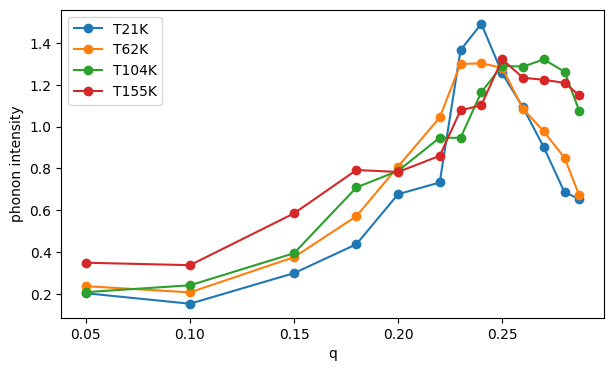

In [9]:
# plotting the second fitting parameter for each phonons as a function of q at T
fig, ax = plt.subplots(1,1,figsize=(7,4))
CDF_intensity = dict( T21K = np.zeros(exp._q_size), T62K = np.zeros(exp._q_size), T104K = np.zeros(exp._q_size), T155K = np.zeros(exp._q_size))
for temperature_char in exp._temperature_list_string:
    for q_index in range(exp._q_size):
        CDF_intensity[temperature_char][q_index] = exp.Fit_results[temperature_char]['optimized_parameters'][q_index][5]
    ax.plot(exp._q_list, CDF_intensity[temperature_char], '-o', label = temperature_char)
ax.set_xlabel('q')
ax.set_ylabel('phonon intensity')
ax.legend()


22.220000000000002


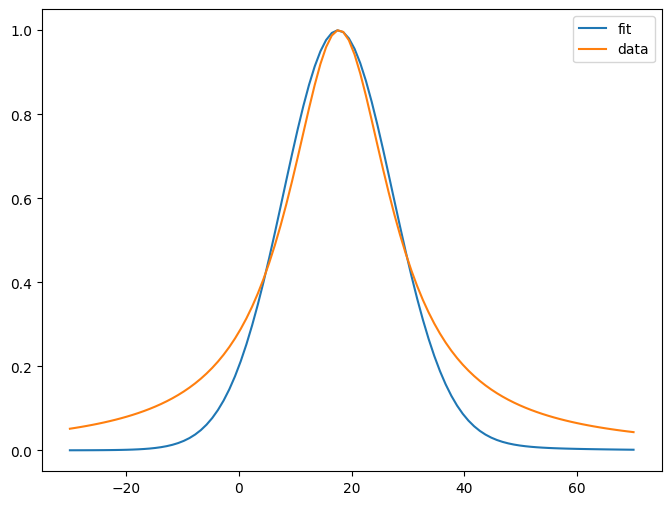

In [ ]:
def fun_chi(x,A,Gamma,Delta):
        normalization_factor = 1/2 * 1/np.sqrt(Delta**2)
        chi = 1/(Delta**2 - (x + 1j*(Gamma))**2)
        return np.imag(chi * normalization_factor)*A

def fun_S(x,A,Gamma,Delta,T):
    return 2/(1-np.exp(-x/T))*fun_chi(x,A,Gamma,Delta)

def fun_S_convoluted(x,Gamma,Delta,T):
    x_left = min(x)
    x_right = max(x)
    x_left_shifted = x_left - (x_right + x_left)/2
    x_right_shifted = x_right - (x_right + x_left)/2
    x_gaussian = np.linspace(x_left_shifted,x_right_shifted,len(x))
    res = exp._resolution
    y = fun_S(x,1,Gamma,Delta,T)
    y_conv = convolve(y, mf.fun_gaussian(x_gaussian,0,1,res), mode='same')
    return y_conv/max(y_conv)
    


# fit CDF with fun_S_convoluted
cdf_index = 8
fig, ax = plt.subplots(1,1,figsize=(8,6))
temperature_char = 'T21K'
temperature = 21*0.086
popt = exp.Fit_results[temperature_char]['optimized_parameters'][cdf_index]
# fit the CDF with fun_S_convoluted
x_data = np.linspace(-30,70,100)
y_data = mf.fun_lorentzian(x_data,*popt[4:7])
print(popt[6])
y_data = y_data/max(y_data)
p0 = [0.2,5,temperature]
epsilon = 0.01
bounds = ([0,0,temperature],[30,30,temperature+epsilon])
sigma = np.ones(len(x_data))
sigma[(x_data>0)&(x_data<30)] = 0.3
popt, pcov = curve_fit(fun_S_convoluted, x_data, y_data, p0 = p0, bounds=bounds,sigma = sigma)


ax.plot(x_data, fun_S_convoluted(x_data,*popt), label = 'fit')
ax.plot(x_data, y_data, label = 'data')
ax.legend()


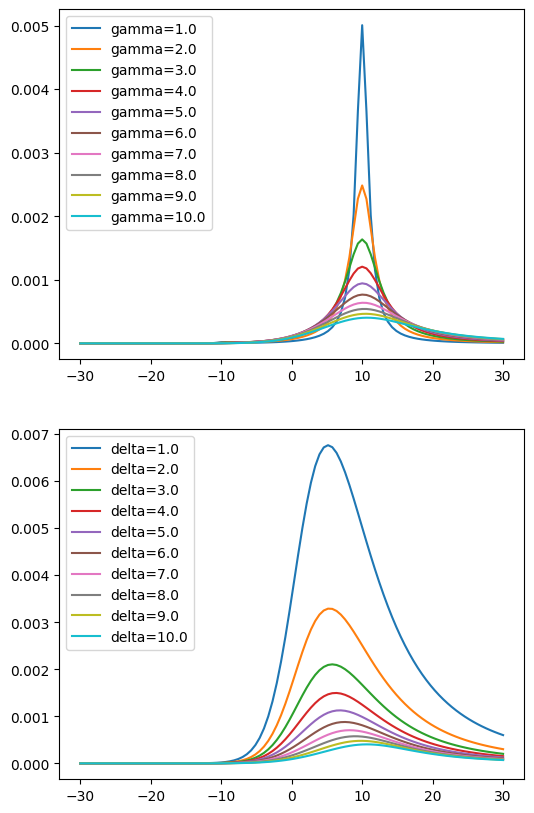

In [ ]:
#plot fun_S with different gamma and delta and with a fixed temperature and A=1
# write a for loop to do it
fig, axs = plt.subplots(2,1,figsize=(6,10))
gamma_list = np.linspace(1,10,10)
delta_list = np.linspace(1,10,10)
temperature = 21*0.086
A=1

for i,gamma in enumerate(gamma_list):
    delta = 10
    ax = axs[0]
    x = np.linspace(-30,30,100)
    y = fun_S(x,A,gamma,delta,temperature)
    ax.plot(x,y,label='gamma='+str(gamma))
    ax.legend()
for i,delta in enumerate(delta_list):
    gamma = 10
    ax = axs[1]
    x = np.linspace(-30,30,100)
    y = fun_S(x,A,gamma,delta,temperature)
    ax.plot(x,y,label='delta='+str(delta))
    ax.legend()







# Problems
1. The FWHM of the CDF is too close to the resolution. Super hard to extract the FWHM before convolution because it's too close to zero. Hard to fit...